# Step 1: Importing packages and libraries

In [2]:
# !pip install transformers

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import ast
from transformers import BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Loading datatset and BERT Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# Read the CSV file with specified options
df = pd.read_csv('all_data_embedding.csv')
#df = pd.read_csv('/content/drive/MyDrive/all_data_embedding.csv')

In [39]:
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Sentence_row,Word_count,Sentence,Sentence_no,Word,POS,end_labels,subtoken,wort_index,contextualized_vectors
0,0,0,45,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,celebrators,NOUN,1.0,"['##ele', '##bra', '##tors']",59,"[0.2368011325597763, 0.7057397961616516, 0.346..."
1,1,1,49,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,66,"[0.24929575622081757, 0.2448728382587433, 0.05..."
2,2,2,63,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,groom,NOUN,1.0,NaN,80,"[-0.31842100620269775, -0.00436730170622468, -..."
3,3,3,65,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,brother,NOUN,1.0,NaN,83,"[0.19683638215065002, 0.23691430687904358, -0...."
4,4,4,72,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,90,"[-0.11486552655696869, 0.1675049066543579, 0.3..."


In [40]:
model_ckpt = "bert-base-cased"
model = BertModel.from_pretrained(model_ckpt)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
df.isnull().sum()

Unnamed: 0.2                  0
Unnamed: 0.1                  0
Unnamed: 0                    0
Sentence_row                  0
Word_count                    0
Sentence                      0
Sentence_no                   0
Word                          0
POS                           0
end_labels                    0
subtoken                  20036
wort_index                    0
contextualized_vectors        0
dtype: int64

In [42]:
df_fin = df.iloc[:,3:] # optional
df_fin.head()

,Sentence_row,Word_count,Sentence,Sentence_no,Word,POS,end_labels,subtoken,wort_index,contextualized_vectors
0,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,celebrators,NOUN,1.0,"['##ele', '##bra', '##tors']",59,"[0.2368011325597763, 0.7057397961616516, 0.346..."
1,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,66,"[0.24929575622081757, 0.2448728382587433, 0.05..."
2,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,groom,NOUN,1.0,NaN,80,"[-0.31842100620269775, -0.00436730170622468, -..."
3,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,brother,NOUN,1.0,NaN,83,"[0.19683638215065002, 0.23691430687904358, -0...."
4,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,90,"[-0.11486552655696869, 0.1675049066543579, 0.3..."


# Basic Operations

In [43]:
df_fin.shape

(20591, 10)

In [44]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sentence_row            20591 non-null  object 
 1   Word_count              20591 non-null  int64  
 2   Sentence                20591 non-null  object 
 3   Sentence_no             20591 non-null  int64  
 4   Word                    20591 non-null  object 
 5   POS                     20591 non-null  object 
 6   end_labels              20591 non-null  float64
 7   subtoken                555 non-null    object 
 8   wort_index              20591 non-null  int64  
 9   contextualized_vectors  20591 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.6+ MB


In [45]:
df_fin.isnull().sum()

Sentence_row                  0
Word_count                    0
Sentence                      0
Sentence_no                   0
Word                          0
POS                           0
end_labels                    0
subtoken                  20036
wort_index                    0
contextualized_vectors        0
dtype: int64

In [49]:
# Drop rows with missing data
#df_fin = df_fin.dropna(subset=['contextualized_vectors'])

In [50]:
#df_fin.isnull().sum()

# EDA and Preprocessing

# Group by a Single Column and Count Frequencies:
To count the frequencies of each unique value in a specific column, you can use the groupby method followed by the count() method.

In [51]:
# Example: Count frequencies of each POS tag
pos_counts = df_fin.groupby('POS')['Word'].count()
pos_counts

POS
ADJ          3
DET          3
NOUN      9149
NUM          9
PRON     11393
PROPN       21
VERB        13
Name: Word, dtype: int64

# Group by Multiple Columns and Calculate Summary Statistics:
You can group by multiple columns and calculate summary statistics like mean, median, or standard deviation.

In [52]:
# Example: Calculate mean wort_index for each POS tag
pos_mean = df_fin.groupby('POS')['wort_index'].mean()
print(pos_mean)


POS
ADJ      34.333333
DET       1.000000
NOUN     14.597880
NUM       8.555556
PRON     14.074344
PROPN    10.904762
VERB     20.000000
Name: wort_index, dtype: float64


# Count Unique Values within Groups:
You can count unique values within groups using the nunique() method.

In [53]:
# Example: Count unique words within each POS group
pos_unique_words = df_fin.groupby('POS')['Word'].nunique()
print(pos_unique_words)


POS
ADJ         3
DET         1
NOUN     2009
NUM         1
PRON       59
PROPN      10
VERB        6
Name: Word, dtype: int64


# Group by and Filter Data:
You can group by a column and filter data based on group-specific conditions.

In [54]:
# Example: Filter rows where the count of words within each POS group is greater than a threshold
filtered_df = df_fin.groupby('POS').filter(lambda group: len(group) > 100)
filtered_df

,Sentence_row,Word_count,Sentence,Sentence_no,Word,POS,end_labels,subtoken,wort_index,contextualized_vectors
0,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,celebrators,NOUN,1.0,"['##ele', '##bra', '##tors']",59,"[0.2368011325597763, 0.7057397961616516, 0.346..."
1,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,66,"[0.24929575622081757, 0.2448728382587433, 0.05..."
2,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,groom,NOUN,1.0,NaN,80,"[-0.31842100620269775, -0.00436730170622468, -..."
3,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,brother,NOUN,1.0,NaN,83,"[0.19683638215065002, 0.23691430687904358, -0...."
4,Celebration Shooting Turns Wedding Into a Fune...,82,"('Celebration', 'Shooting', 'Turns', 'Wedding'...",0,his,PRON,1.0,NaN,90,"[-0.11486552655696869, 0.1675049066543579, 0.3..."
...,...,...,...,...,...,...,...,...,...,...
20586,270 people died in the 1988 bombing over the S...,13,"('270', 'people', 'died', 'in', 'the', '1988',...",694,bombing,NOUN,0.0,NaN,7,"[0.7685379981994629, 1.1152576208114624, -0.03..."
20587,Libya initially refused to hand over the two...,35,"('Libya', 'initially', 'refused', ' ', 'to', '...",695,them,PRON,0.0,NaN,13,"[0.11229117214679718, 0.1690313071012497, -0.0..."
20588,Libya initially refused to hand over the two...,35,"('Libya', 'initially', 'refused', ' ', 'to', '...",695,they,PRON,0.0,NaN,21,"[0.42757537961006165, 0.07952315360307693, 0.2..."
20589,Opinion polls in Israel show hard - liner Arie...,27,"('Opinion', 'polls', 'in', 'Israel', 'show', '...",697,liner,NOUN,0.0,NaN,10,"[0.5175463557243347, -0.1255677044391632, -0.0..."


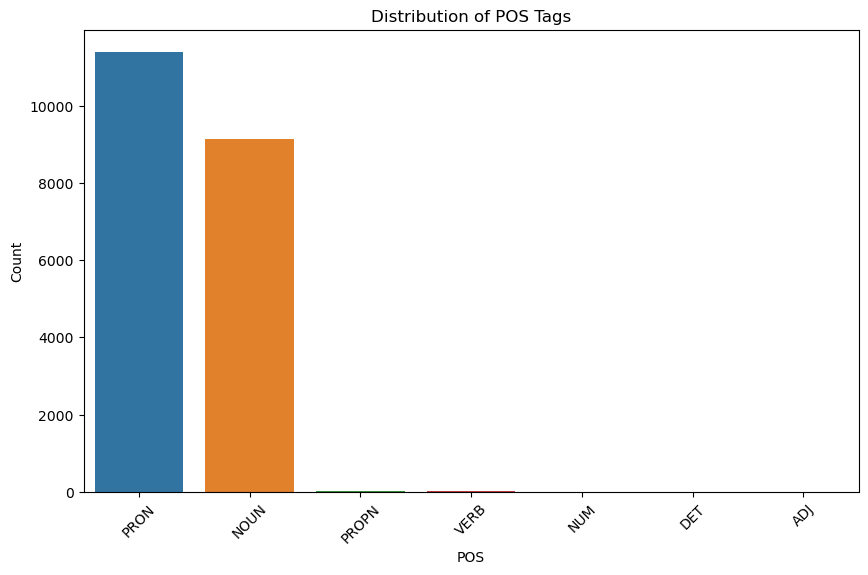

In [55]:
# Plot 1: Distribution of 'POS' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df_fin, x='POS', order=df_fin['POS'].value_counts().index)
plt.xlabel('POS')
plt.ylabel('Count')
plt.title('Distribution of POS Tags')
plt.xticks(rotation=45)
plt.show()

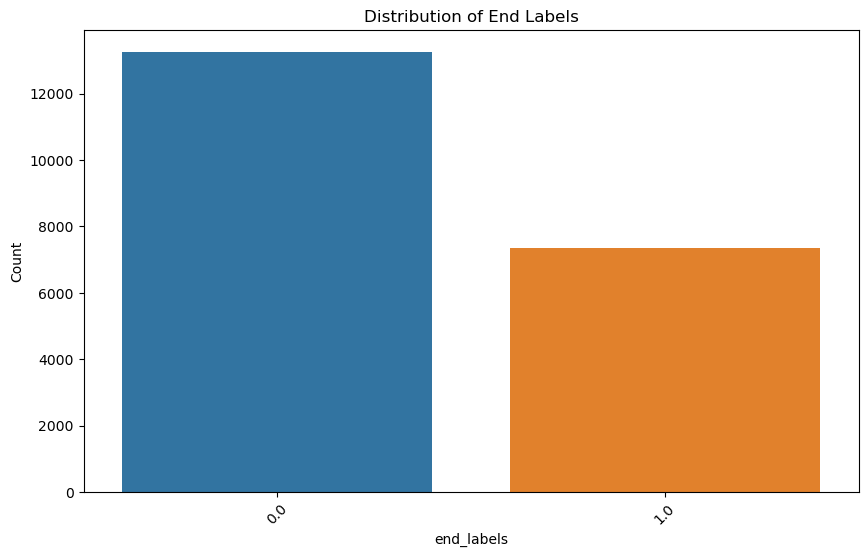

In [56]:
# Plot 2: Distribution of 'end_labels' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df_fin, x='end_labels', order=df_fin['end_labels'].value_counts().index)
plt.xlabel('end_labels')
plt.ylabel('Count')
plt.title('Distribution of End Labels')
plt.xticks(rotation=45)
plt.show()

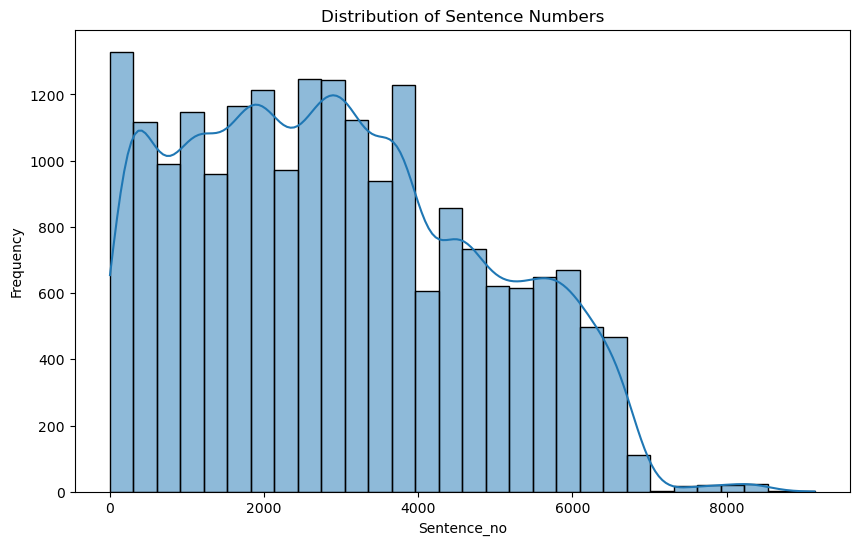

In [57]:
# Plot 3: Distribution of 'Sentence_no' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df_fin, x='Sentence_no', bins=30, kde=True)
plt.xlabel('Sentence_no')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Numbers')
plt.show()

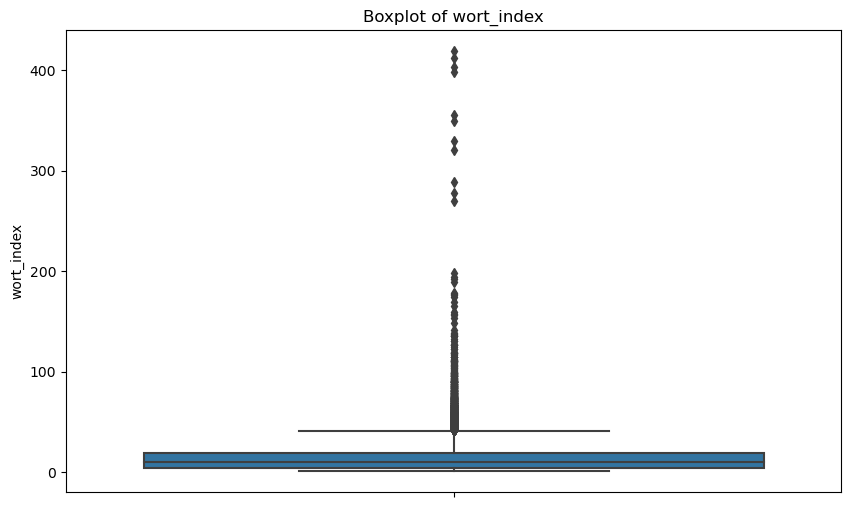

In [58]:
# Plot 4: Boxplot of 'wort_index'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_fin, y='wort_index')
plt.ylabel('wort_index')
plt.title('Boxplot of wort_index')
plt.show()

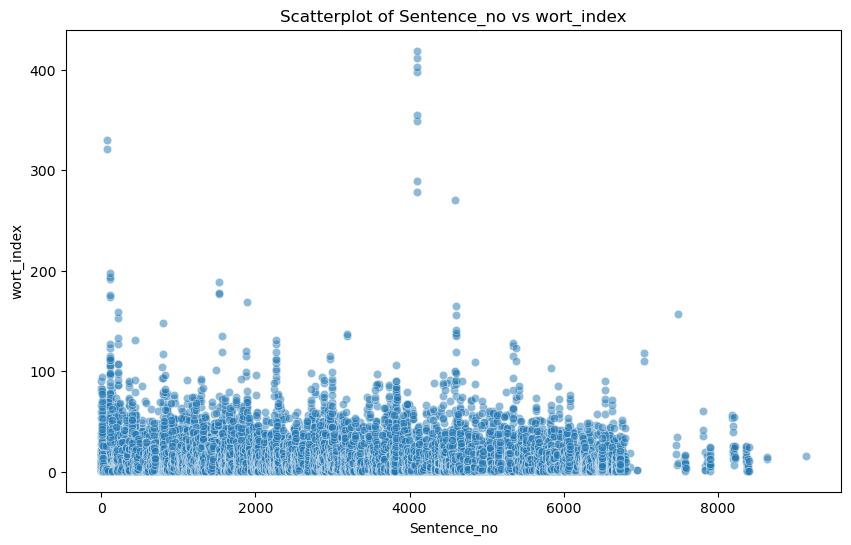

In [59]:
# Plot 5: Example scatterplot (customize as needed)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fin, x='Sentence_no', y='wort_index', alpha=0.5)
plt.xlabel('Sentence_no')
plt.ylabel('wort_index')
plt.title('Scatterplot of Sentence_no vs wort_index')
plt.show()

In [60]:
df_fin["end_labels"]= df_fin["end_labels"].astype(int)

# Prob Architecture Implementation

In [61]:
df_fin['end_labels'].value_counts()

0    13249
1     7342
Name: end_labels, dtype: int64

In [62]:
# Standardize input features
scaler = StandardScaler()
X = np.vstack(df_fin['contextualized_vectors'].apply(literal_eval))
X = scaler.fit_transform(X)

In [63]:
samples=len(X)
indicies=np.arange(samples)
df_fin.index=indicies

In [64]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, df_fin['end_labels'], indicies, test_size=0.2, random_state=30)

In [65]:
# Implement logistic regression or your custom neural network
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy: 0.8417091527069677
F1-Score: 0.7756366139022711
Confusion Matrix:


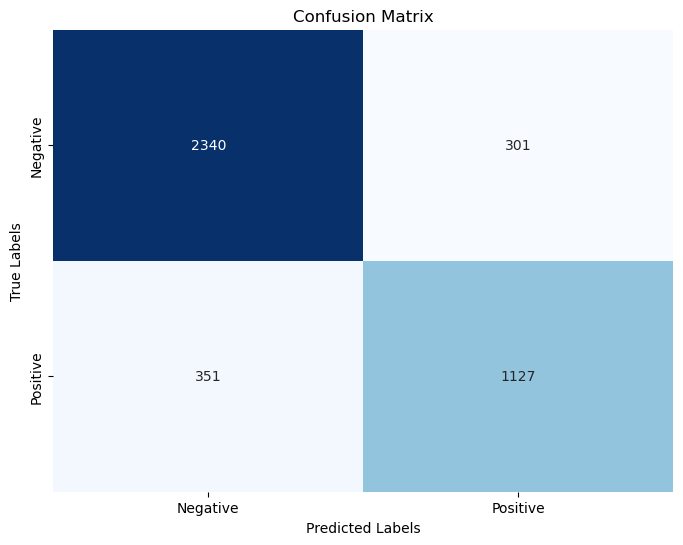

In [66]:

# Evaluate the logistic regression model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Confusion Matrix:")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Analyzing the results


In [121]:
# Extract contextualized vectors
contextualized_vectors = df_fin["contextualized_vectors"]

# Predict pronouns and compare with true labels
test_d = df_fin.loc[indices_test, :]
test_d[["Word", "end_labels", "subtoken", "contextualized_vectors","POS"]]

count_correct_pron=0
count_incorrect_pron=0
all_pron=0
for index, row in test_d.iterrows():
    x_text_word = np.array(literal_eval(row["contextualized_vectors"])).reshape(-1, np.array(literal_eval(row["contextualized_vectors"])).shape[-1])
    y_pred_word = lr_model.predict(x_text_word)
    if row["POS"] == "PRON":
        all_pron+=1
        if y_pred_word[0] == row["end_labels"]:
            #print("correct classify",row["Word"])
            count_correct_pron+=1
        else:
            #print("incorrect classify",row["Word"])
            count_incorrect_pron+=1
print("all_pron",all_pron)
print("correct_pron",count_correct_pron)
print("incorrect_pron",count_incorrect_pron)
            
            
            
        
    #print("Prediction for words in '{}': {} True Label : {} subtoken : {}".format(row["Word"], y_pred_word[0], row["end_labels"],row["subtoken"]))

all_pron 2245
correct_pron 1636
incorrect_pron 609


In [122]:
# Extract contextualized vectors
contextualized_vectors = df_fin["contextualized_vectors"]

# Predict nouns and compare with true labels
test_d = df_fin.loc[indices_test, :]
test_d[["Word", "end_labels", "subtoken", "contextualized_vectors","POS"]]

count_correct_noun=0
count_incorrect_noun=0
all_noun=0
for index, row in test_d.iterrows():
    x_text_word = np.array(literal_eval(row["contextualized_vectors"])).reshape(-1, np.array(literal_eval(row["contextualized_vectors"])).shape[-1])
    y_pred_word = lr_model.predict(x_text_word)
    if row["POS"] == "NOUN":
        all_noun+=1
        if y_pred_word[0] == row["end_labels"]:
            #print("correct classify",row["Word"])
            count_correct_noun+=1
        else:
            #print("incorrect classify",row["Word"])
            count_incorrect_noun+=1
print("all_noun",all_noun)
print("correct_noun",count_correct_noun)
print("incorrect_noun",count_incorrect_noun)

all_noun 1866
correct_noun 1746
incorrect_noun 120


In [73]:
# Extract contextualized vectors
contextualized_vectors = df_fin["contextualized_vectors"]

# Predict PROPN and compare with true labels
test_d = df_fin.loc[indices_test, :]
test_d[["Word", "end_labels", "subtoken", "contextualized_vectors","POS"]]

count_correct_propn=0
count_incorrect_propn=0
all_propn=0
for index, row in test_d.iterrows():
    x_text_word = np.array(literal_eval(row["contextualized_vectors"])).reshape(-1, np.array(literal_eval(row["contextualized_vectors"])).shape[-1])
    y_pred_word = lr_model.predict(x_text_word)
    if row["POS"] == "PROPN":
        all_propn+=1
        if y_pred_word[0] == row["end_labels"]:
            #print("correct classify",row["Word"])
            count_correct_propn+=1
        else:
            #print("incorrect classify",row["Word"])
            count_incorrect_propn+=1
print("all_propn",all_propn)
print("correct_propn",count_correct_propn)
print("incorrect_propn",count_incorrect_propn)
            

all_propn 3
correct_propn 3
incorrect_propn 0


In [81]:


# Extract contextualized vectors
contextualized_vectors = df_fin["contextualized_vectors"]

# Counting the number of correctly and incorrectly classified names with and without subtokens
test_d = df_fin.loc[indices_test, :]
test_d[["Word", "end_labels", "subtoken", "contextualized_vectors","POS"]]

count_correct_noun_subtoken=0
count_incorrect_noun_subtoken=0
all_noun_subtoken=0
all_noun_without_subtoken=0
count_correct_noun_without_subtoken=0
count_incorrect_noun_without_subtoken=0
for index, row in test_d.iterrows():
    x_text_word = np.array(literal_eval(row["contextualized_vectors"])).reshape(-1, np.array(literal_eval(row["contextualized_vectors"])).shape[-1])
    y_pred_word = lr_model.predict(x_text_word)
    if row["POS"] == "NOUN" and type(row["subtoken"]) != float:
        all_noun_subtoken+=1
        if y_pred_word[0] == row["end_labels"]:
            #print("correct classify",row["Word"])
            count_correct_noun_subtoken+=1
        else:
            #print("incorrect classify",row["Word"])
            count_incorrect_noun_subtoken+=1
    if row["POS"] == "NOUN" and type(row["subtoken"]) == float:
        all_noun_without_subtoken+=1
        if y_pred_word[0] == row["end_labels"]:
            #print("correct classify",row["Word"])
            count_correct_noun_without_subtoken+=1
        else:
            #print("incorrect classify",row["Word"])
            count_incorrect_noun_without_subtoken+=1
            
        
print("all_noun_subtoken",all_noun_subtoken)
print("count_correct_noun_subtoken",count_correct_noun_subtoken)
print("count_incorrect_noun_subtoken",count_incorrect_noun_subtoken)
print("-----------------------------------------------")
print("all_noun_without_subtoken",all_noun_without_subtoken)
print("count_correct_noun_without_subtoken",count_correct_noun_without_subtoken)
print("count_incorrect_noun_without_subtoken",count_incorrect_noun_without_subtoken)

all_noun_subtoken 118
count_correct_noun_subtoken 93
count_incorrect_noun_subtoken 25
-----------------------------------------------
all_noun_without_subtoken 1748
count_correct_noun_without_subtoken 1653
count_incorrect_noun_without_subtoken 95


In [115]:
filtered_pron_without_subtoken = test_d.loc[(test_d['POS'] =="PRON") & (test_d['subtoken'].isnull())]
len(filtered_pron_without_subtoken)

2243

In [116]:
# Only two pronouns in test-data bekamme from tokenizer subtoken 
filtered_pron_subtoken = test_d.loc[(test_d['POS'] =="PRON") & (test_d['subtoken'].notnull())]
len(filtered_pron_subtoken)

2

In [38]:
# Implement a custom neural network with optimization techniques
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BinaryClassificationNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.ReLU()(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

input_dim = X_train.shape[1]
hidden_dim = 50
learning_rate = 0.01
epochs = 40

model = BinaryClassificationNN(input_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


Epoch 1/40, Loss: 0.7070978283882141
Epoch 2/40, Loss: 0.5222893357276917
Epoch 3/40, Loss: 0.4194794297218323
Epoch 4/40, Loss: 0.3924577534198761
Epoch 5/40, Loss: 0.37089207768440247
Epoch 6/40, Loss: 0.3543684780597687
Epoch 7/40, Loss: 0.3419238328933716
Epoch 8/40, Loss: 0.3325795829296112
Epoch 9/40, Loss: 0.32483696937561035
Epoch 10/40, Loss: 0.3182048797607422
Epoch 11/40, Loss: 0.310955673456192
Epoch 12/40, Loss: 0.3035556972026825
Epoch 13/40, Loss: 0.2974562346935272
Epoch 14/40, Loss: 0.2918960154056549
Epoch 15/40, Loss: 0.28644463419914246
Epoch 16/40, Loss: 0.2812170088291168
Epoch 17/40, Loss: 0.2759120762348175
Epoch 18/40, Loss: 0.27099645137786865
Epoch 19/40, Loss: 0.2666110396385193
Epoch 20/40, Loss: 0.2619054615497589
Epoch 21/40, Loss: 0.25712850689888
Epoch 22/40, Loss: 0.252923846244812
Epoch 23/40, Loss: 0.24857968091964722
Epoch 24/40, Loss: 0.24440649151802063
Epoch 25/40, Loss: 0.2406601756811142
Epoch 26/40, Loss: 0.2360161393880844
Epoch 27/40, Loss: 

In [39]:
# Evaluate the custom neural network
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    predicted_labels = (test_outputs > 0.5).float()
    accuracy = (predicted_labels == torch.tensor(y_test.values, dtype=torch.float32)).float().mean()

print("Custom Neural Network Accuracy:", accuracy.item())

Custom Neural Network Accuracy: 0.8696285486221313


F1-Score for Custom Neural Network: 0.8150189459180158


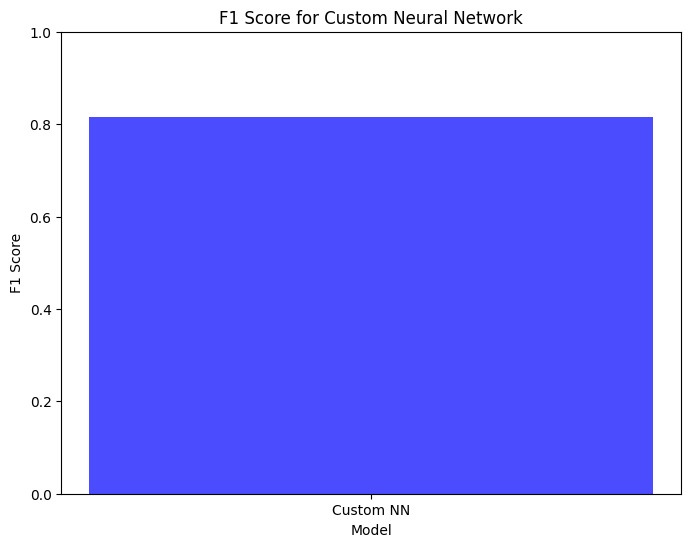

In [42]:
# F1 Score for Custom Neural Network
f1_custom_nn = f1_score(y_test, predicted_labels)

print("F1-Score for Custom Neural Network:", f1_custom_nn)

# Plot F1 Score
plt.figure(figsize=(8, 6))
plt.title("F1 Score for Custom Neural Network")
plt.bar(["Custom NN"], [f1_custom_nn], color='b', alpha=0.7)
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.show()

Confusion Matrix for Custom Neural Network:
[[2399  242]
 [ 295 1183]]


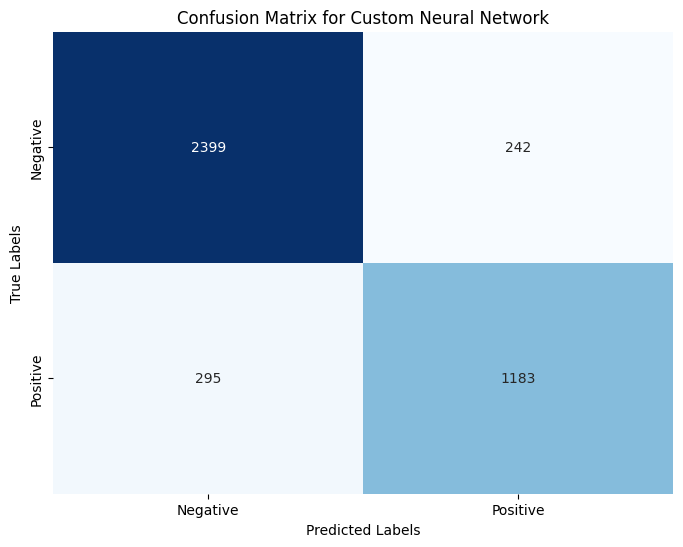

In [43]:

# Confusion Matrix for Custom Neural Network
confusion = confusion_matrix(y_test, predicted_labels)

print("Confusion Matrix for Custom Neural Network:")
print(confusion)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Custom Neural Network')
plt.show()